# Kapazitätsplanung mit Facebook Prophet

Dieses Jupyter Notebook ist wie folgt aufgebaut:  

1. Importiere Packages und Daten
2. Datenaufbereitung
3. Explorative Datenanalyse (EDA)
4. Einfache Durchsatz-Vorhersagen mittels Prophet
    1. Fein-granulares Modell am Beispiel eines Interfaces
    2. Welches Interface durchbricht die Kapazitätsgrenze? - Modell des wöchentlichen Maximums

# Importiere Packages und Daten

In [1]:
# importiere packages
import pandas as pd
import collections
import math
import matplotlib.pyplot as plt
import matplotlib.font_manager
from fbprophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [2]:
# Setze Layout-Optionen
pd.set_option('display.float_format', '{:.2f}'.format)
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 85%; }
</style>
"""))

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

In [36]:
# Importiere Daten
df = pd.read_csv('../data/interface-data-hourly.csv', header=None, names=["ts_epoch", "host", "interface", "capacity", "y"], sep=",")
# Zeige Datenausschnitt (nur zur Übersicht hier die Spalte y in throughput geändert)
df.sample(10).rename({'y': 'throughput'}, axis=1).reset_index(drop=True)

,ts_epoch,host,interface,capacity,throughput
0,1551160800.00,Frankfurt,interface3,40,6.34
1,1561204800.00,Hamburg,interface3,20,4.45
2,1575054000.00,Berlin,interface1,2,0.71
3,1570399200.00,Munich,interface3,20,4.68
4,1594166400.00,Hamburg,interface1,4,0.96
5,1561723200.00,Frankfurt,interface2,20,4.75
6,1570132800.00,Berlin,interface1,2,0.54
7,1591257600.00,Berlin,interface3,20,4.01
8,1572087600.00,Berlin,interface2,8,2.42
9,1596171600.00,Hamburg,interface2,4,0.97


# Datenaufbereitung

Hier werden Timestamps in ein geeignetes Format konvertiert und der Dataframe sortiert.

In [4]:
# Konvertiere Epoch zu Datetime Zeitstempel
df['ds'] = pd.to_datetime(df['ts_epoch'],unit='s')
# Entferne 'ts_epoch'
df.drop('ts_epoch', axis=1, inplace=True)
# Sortiere nach Interface und Zeit
df.sort_values(['host', 'interface', 'ds'], inplace=True)
df.reset_index(drop=True, inplace=True)

# EDA

Dieser Abschnitt soll eine Übersicht über den vorhandenen Datensatz liefern.

In [5]:
print("Unique Hosts: {}".format(sorted(df.host.unique())))
print("Unique Interfaces: {}".format(sorted(df.interface.unique())))
print("Unique Capacities: {}".format(sorted(df.capacity.unique())))

Unique Hosts: ['Berlin', 'Frankfurt', 'Hamburg', 'Munich']
Unique Interfaces: ['interface1', 'interface2', 'interface3']
Unique Capacities: [2, 4, 8, 20, 40]


In [6]:
# Zeige die Kapazitäten der Interfaces
df.groupby(['host', 'interface'])['capacity'].first().reset_index()

,host,interface,capacity
0,Berlin,interface1,2
1,Berlin,interface2,8
2,Berlin,interface3,20
3,Frankfurt,interface1,20
4,Frankfurt,interface2,20
5,Frankfurt,interface3,40
6,Hamburg,interface1,4
7,Hamburg,interface2,4
8,Hamburg,interface3,20
9,Munich,interface1,2


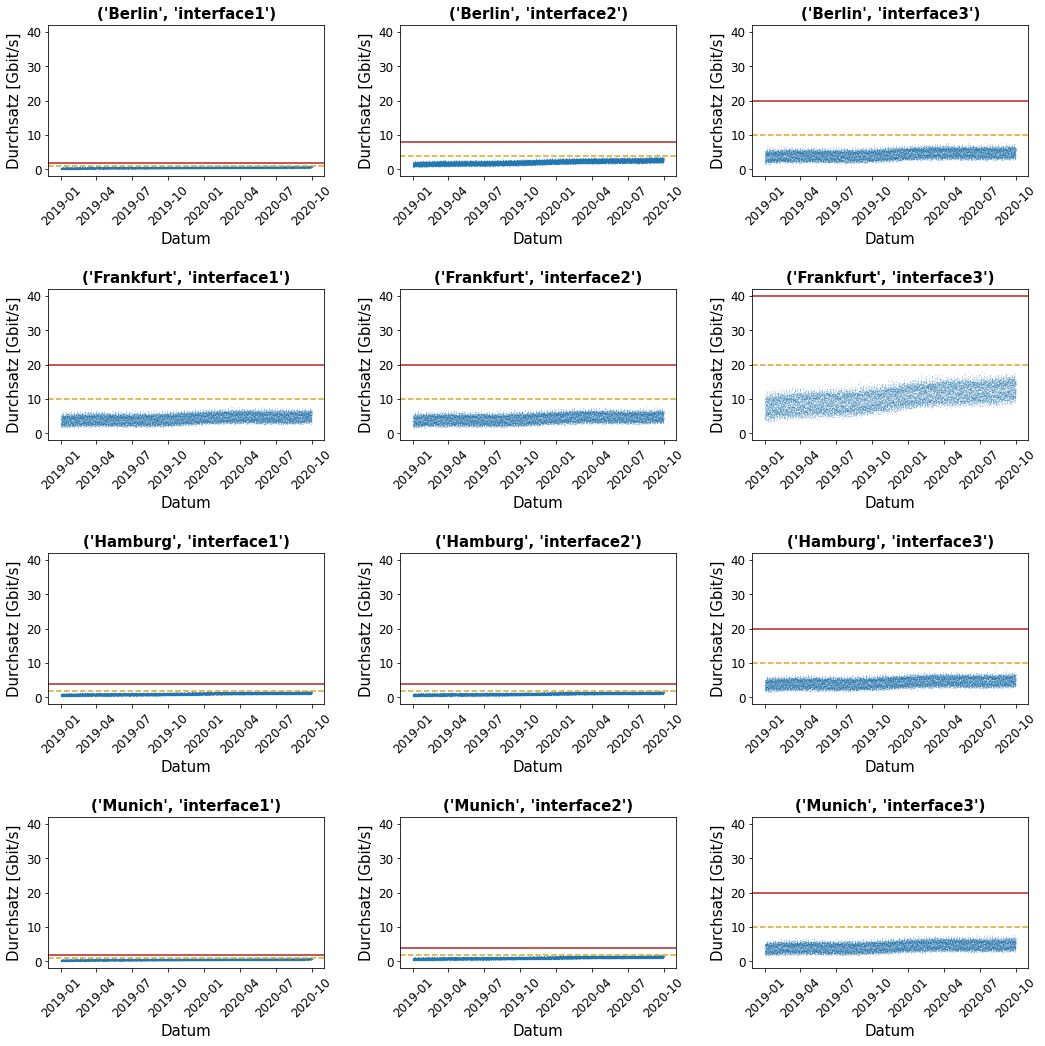

In [7]:
# Alle Interfaces gemeinsam plotten
fig, axes = plt.subplots(df.host.nunique(), df.interface.nunique(), figsize=(15,15))
for (interface, group), ax in zip(df.groupby(['host', 'interface']), axes.flatten()):
    group.plot(x='ds', y='y', kind='scatter', s=0.005, ax=ax)
    ax.axhline(y=group.capacity.max(), color='firebrick')
    ax.axhline(y=group.capacity.max()/2, color='goldenrod', linestyle='--')
    ax.set_title(interface, fontweight="bold", size=15) # Title
    ax.set_ylim(-2, df.capacity.max()+2)
    ax.set_ylabel('Durchsatz [Gbit/s]', fontsize = 15) # Y label
    ax.set_xlabel('Datum', fontsize = 15) # X label
    for label in ax.get_xticklabels():
        label.set_rotation(45)
fig.tight_layout(pad=2.0)    

# Einfache Durchsatz-Vorhersagen mittels Prophet

## Fein-granulares Modell am Beispiel eines Interfaces

Hier wählen wir beispielhaft eine Standort-Interface-Kombination aus und stellen eine Vorhersage für den Durchsatz mit Hilfe von Facebook Prophet auf. Die Datengranularität von einer Stunde wird auch für die Vorhersage verwendet.

In [8]:
# Wähle ein Interface
selected_host = 'Munich'
selected_interface = 'interface2'
df_single_interface = df[(df.host == selected_host) & (df.interface == selected_interface)]

### Detailanalyse des Interfaces

In [9]:
# Reduziere df auf Spalten 'ds' und 'y'
max_capacity = df_single_interface.capacity.max()
cols = ['ds', 'y']
df_model_input = df_single_interface[cols].copy()

# Füge Wochenend-Feature hinzu
def is_saturday(ds):
    date = pd.to_datetime(ds)
    return 1 if date.weekday() == 5 else 0
def is_sunday(ds):
    date = pd.to_datetime(ds)
    return 1 if date.weekday() == 6 else 0
df_model_input['is_saturday'] = df_model_input['ds'].apply(is_saturday)
df_model_input['is_sunday'] = df_model_input['ds'].apply(is_sunday)

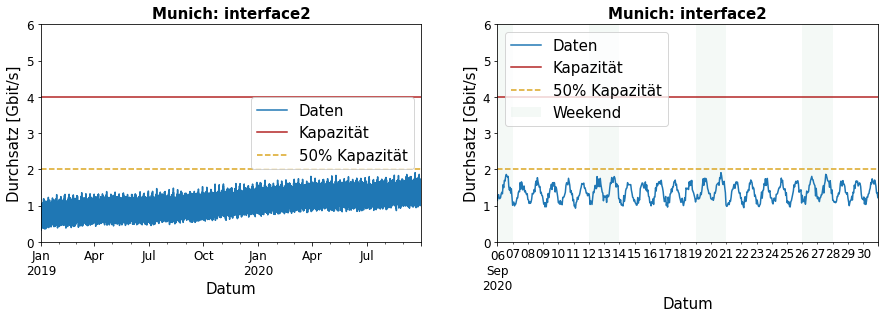

In [10]:
#-------------
# Plotte Daten
#-------------
last_n_datapoints = 600
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
df_model_input.plot(x="ds", y="y", label='Daten', ax=axes[0])
df_model_input[-last_n_datapoints:].plot(x="ds", y="y", label='Daten', ax=axes[1])
axes[0].axhline(y=max_capacity, label='Kapazität', color='firebrick')
axes[0].axhline(y=max_capacity/2, label='50% Kapazität', color='goldenrod', linestyle='--')
axes[1].axhline(y=max_capacity, label='Kapazität', color='firebrick')
axes[1].axhline(y=max_capacity/2, label='50% Kapazität', color='goldenrod', linestyle='--')
#-------------
#-------------

# Setze Plot-Eigenschaften
axes[0].set_title(selected_host + ': ' + selected_interface, fontweight="bold", size=15) # Title
axes[0].set_ylim(0, max_capacity+2)
axes[0].set_ylabel('Durchsatz [Gbit/s]', fontsize = 15) # Y label
axes[0].set_xlabel('Datum', fontsize = 15) # X label
axes[0].tick_params(axis='both', which='major')
axes[1].set_title(selected_host + ': ' + selected_interface, fontweight="bold", size=15) # Title
axes[1].set_ylim(0, max_capacity+2)
axes[1].set_ylabel('Durchsatz [Gbit/s]', fontsize = 15) # Y label
axes[1].set_xlabel('Datum', fontsize = 15) # X label
# Highlight der Wochenenden
we_label = "Wochenende"
i=0
while i < len(df_model_input[-last_n_datapoints:].ds)-1:
    if df_model_input[-last_n_datapoints:].ds.iloc[i].weekday() >= 5:
        axes[1].axvspan(df_model_input[-last_n_datapoints:].ds.iloc[i], df_model_input[-last_n_datapoints:].ds.iloc[i + 1], label=we_label, facecolor='seagreen', edgecolor='none', alpha=.05)
        we_label = "_nolegend_"
        i += 1
    else:
        i += 1
axes[0].legend(loc=0, prop={'size': 15})
axes[1].legend(loc=0, prop={'size': 15})

### Bilde Modell und erzeuge Prognose

In [11]:
# Methode zum Erstellen einer Prognose auf den Daten 'df'
# 'future_periods' spezifiziert die Anzahl der Vorhersage-Intervalle
def create_forecast(df, future_periods, interval, daily, weekend_regressor):
    m = Prophet(
        growth='linear',
        changepoint_prior_scale=0.01,
        changepoint_range=0.80,
        interval_width = 0.95,
        seasonality_mode='additive',
        seasonality_prior_scale=1,
        daily_seasonality=daily,
        weekly_seasonality=False,
        yearly_seasonality=False
    )
    m.add_seasonality(name='yearly',period=365, fourier_order=1)

    if weekend_regressor:
        # Add weekend regressor
        m.add_regressor('is_saturday')
        m.add_regressor('is_sunday')

    # Fit
    m.fit(df)
    # Erzeuge Future Dataframe
    future = m.make_future_dataframe(periods=future_periods, freq=interval)
    if weekend_regressor:
        future['is_saturday'] = future['ds'].apply(is_saturday)
        future['is_sunday'] = future['ds'].apply(is_sunday)
    # Prognose
    forecast = m.predict(future)
    return forecast, m

In [12]:
# Modellparameter
future_periods = 24*457 # till end of 2021
interval = '60min'
daily = True
weekend_regressor = True
# Erzeuge Vorhersage
forecast, m = create_forecast(df_model_input, future_periods, interval, daily, weekend_regressor)

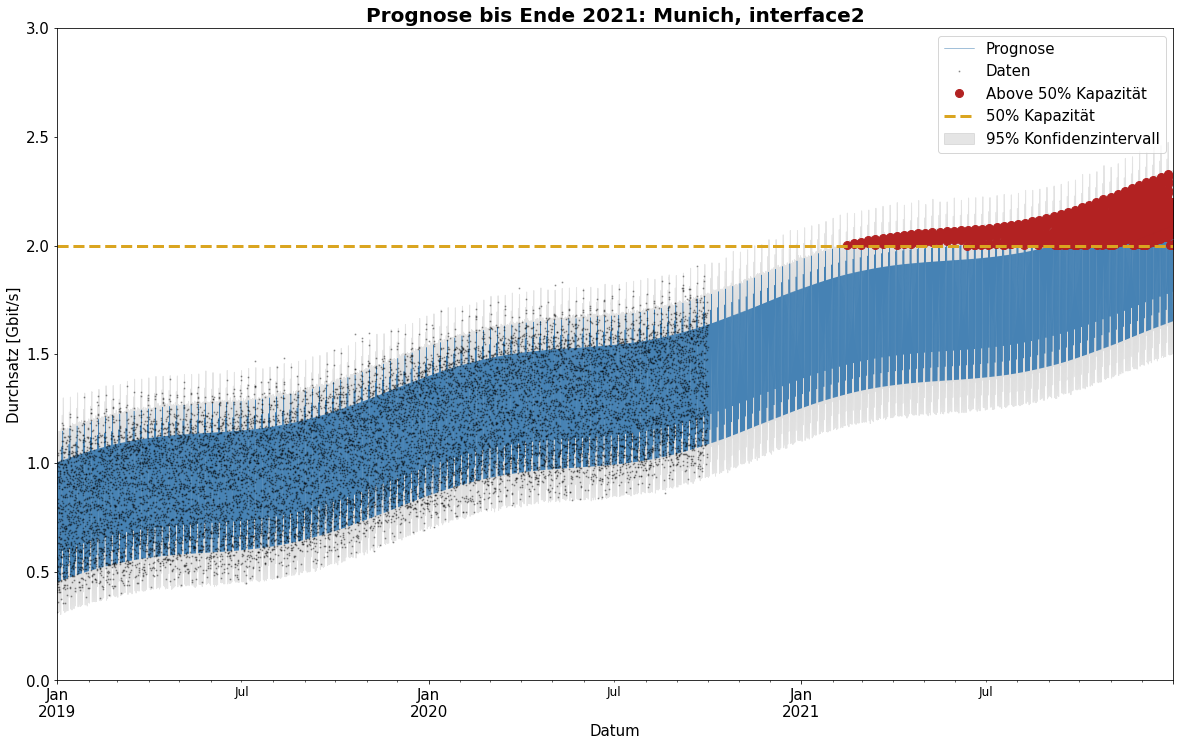

In [13]:
# Daten, die die Kapazitätsgrenze überschreiten
above_threshold = forecast[forecast.yhat > max_capacity/2]

#----------------
# Plotte Prognose
#----------------
ax = forecast.plot(x="ds", y="yhat", label='Prognose', color="steelblue", linewidth=0.5)
ax.fill_between(forecast['ds'].values, forecast.yhat_lower, forecast.yhat_upper, label='95% Konfidenzintervall', color='grey', alpha=.2)
df_model_input.plot(x="ds", y="y", label='Daten', ax=ax, marker='o', ms = 1, color="black", alpha=0.3, figsize=(20, 12), linestyle = 'None')
if not above_threshold.empty:
    above_threshold.plot(x="ds", y="yhat", label='Above 50% Kapazität', ax=ax, marker='o', ms = 8, color="firebrick", alpha=1, linestyle = 'None')
#----------------
#----------------
    
# Setze Plot-Eigenschaften
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim(0, max_capacity/2+1)
ax.set_title('Prognose bis Ende 2021: {}, {}'.format(selected_host, selected_interface), fontweight="bold", size=20) # Title
ax.set_ylabel('Durchsatz [Gbit/s]', fontsize = 15) # Y label
ax.set_xlabel('Datum', fontsize = 15) # X label
ax.axhline(y=max_capacity/2, label='50% Kapazität', color='goldenrod', linestyle='--', linewidth=3)
ax.legend(loc=0, prop={'size': 15})

Im Folgenden erstellen wir nochmal einen Detailausschnitt, der den Tagesgang besser zeigt.

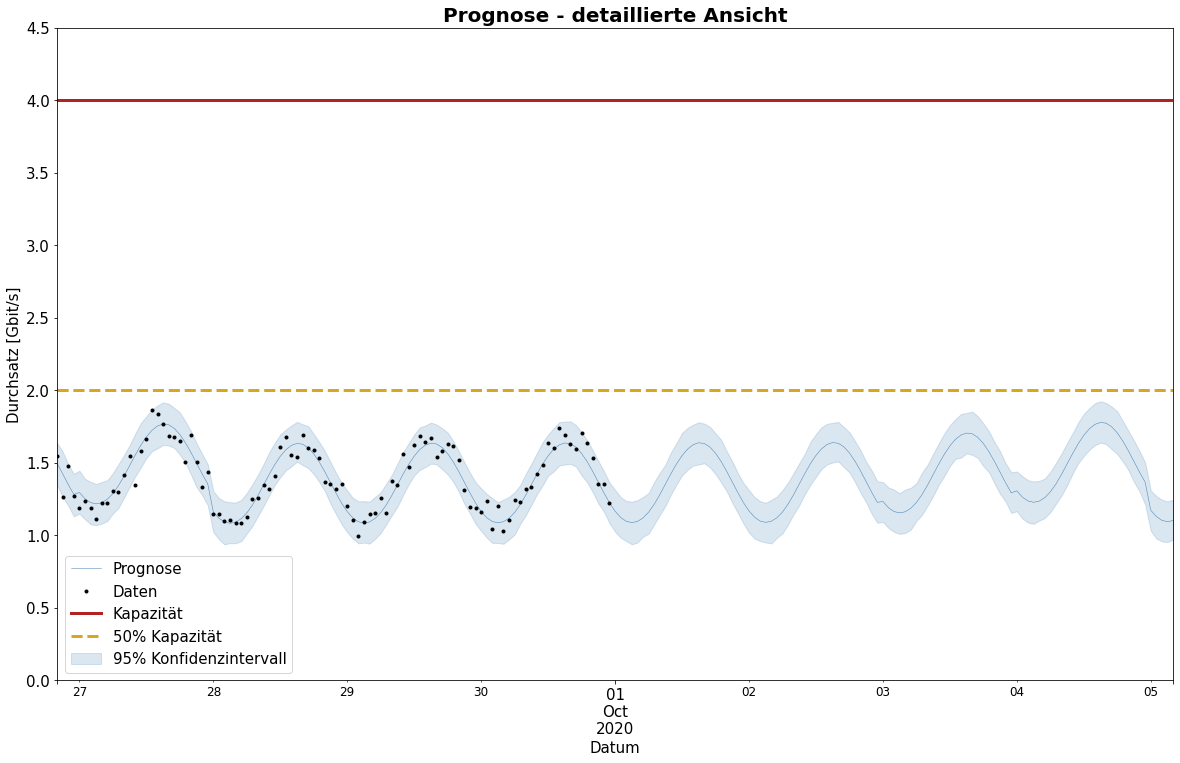

In [14]:
# Wähle Teildaten aus
data_num = 100
forecast_num = 100
forecast_sample = forecast[len(df_model_input)-data_num:len(df_model_input)+1+forecast_num]
above_threshold = forecast_sample[forecast_sample.yhat > max_capacity/2]

#-----
# Plot
#-----
ax = forecast_sample.plot(x="ds", y="yhat", label='Prognose', color="steelblue", linewidth=0.5)
ax.fill_between(forecast_sample['ds'].values, forecast_sample.yhat_lower, forecast_sample.yhat_upper, label='95% Konfidenzintervall', color='steelblue', alpha=.2)
df_model_input[-data_num:].plot(x="ds", y="y", label='Daten', ax=ax, marker='o', ms = 3, color="black", alpha=1, figsize=(20, 12), linestyle = 'None')
if not above_threshold.empty:
    above_threshold.plot(x="ds", y="yhat", ax=ax, label='Above 50% Kapazität', marker='o', ms = 4, color="firebrick", alpha=0.5, linestyle = 'None')
ax.axhline(y=max_capacity, label='Kapazität', color='firebrick', linewidth=3)
ax.axhline(y=max_capacity/2, label='50% Kapazität', color='goldenrod', linestyle='--', linewidth=3)
#-----
#-----

# Setze Plot-Eigenschaften
ax.set_title('Prognose - detaillierte Ansicht', fontweight="bold", size=20) # Title
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim(0, max_capacity+0.5)
ax.set_ylabel('Durchsatz [Gbit/s]', fontsize = 15) # Y label
ax.set_xlabel('Datum', fontsize = 15) # X label
ax.legend(loc=0, prop={'size': 15})

### Modell-Komponenten

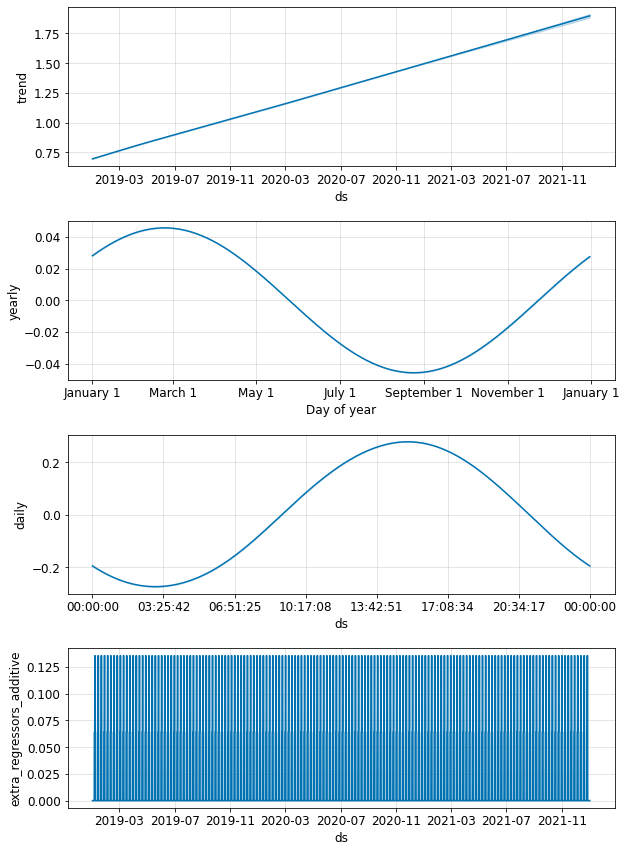

In [15]:
# Plotte Modell-Komponenten
components_fig = m.plot_components(forecast)

### Wöchentlicher Maximaldurchsatz

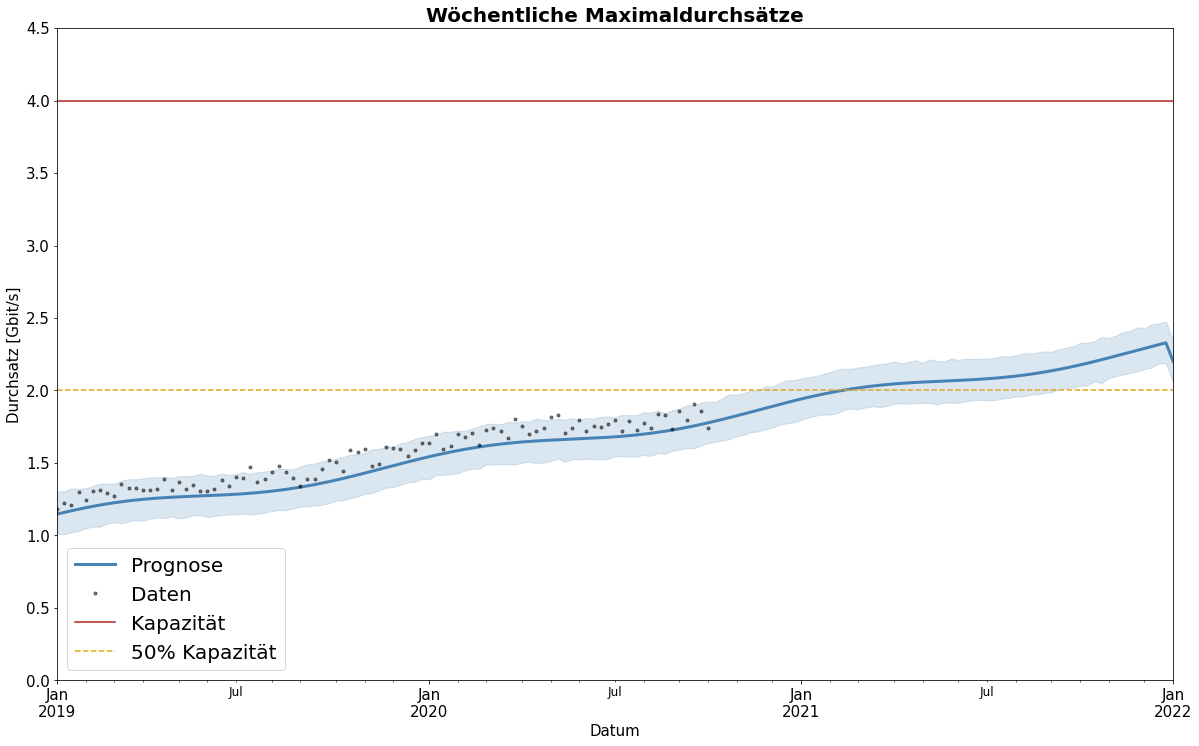

In [16]:
# Wähle den wöchentlichen Maximaldurchsatz aus
forecast_index = forecast.set_index('ds')
df_model_input_index = df_model_input.set_index('ds')
forecast_max = forecast_index.groupby(pd.Grouper(freq='W-MON')).agg(lambda df: df.loc[df.yhat.idxmax()]).reset_index()
df_model_input_max = df_model_input_index.groupby(pd.Grouper(freq='W-MON')).agg(lambda df: df.loc[df.y.idxmax()]).reset_index()

#-----
# Plot
#-----
ax = forecast_max.plot(x="ds", y="yhat", label='Prognose', color="steelblue", linewidth=3)
ax.fill_between(forecast_max['ds'].values, forecast_max.yhat_lower, forecast_max.yhat_upper, color='steelblue', alpha=.2)
df_model_input_max.plot(x="ds", y="y", label='Daten', ax=ax, marker='o', ms = 3, color="black", alpha=0.5, figsize=(20, 12), linestyle = 'None')
ax.axhline(y=max_capacity, label='Kapazität', color='firebrick')
ax.axhline(y=max_capacity/2, label='50% Kapazität', color='goldenrod', linestyle='--')
#-----
#-----

# Setze Plot-Eigenschaften
ax.set_title('Wöchentliche Maximaldurchsätze', fontweight="bold", size=20) # Title
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim(0, max_capacity+0.5)
ax.set_ylabel('Durchsatz [Gbit/s]', fontsize = 15) # Y label
ax.set_xlabel('Datum', fontsize = 15) # X label
ax.legend(loc=0, prop={'size': 20})

## Welches Interface durchbricht die Kapazitätsgrenze? - Modell des wöchentlichen Maximums

### Erkenne kritische Interfaces

Hier prüfen wir alle Router-Interface-Kombination und lassen uns anzeigen, ob die Vorhersage der wöchentlichen Max-Werte im Vorhersagezeitraum die kritische 50%-Kapazitätsgrenze überschreitet.

In [17]:
# Gruppiere nach Host und Interface
df_grouped = df.groupby(['host', 'interface'])

is_critical_dict = collections.defaultdict(list)

# Iteration über jede Gruppe
for group_name, df_group in df_grouped:
    ## Max Kapazitätsgrenze
    max_capacity = df_group.capacity.max()
    ## Setze Zeitstempel als Index
    df_date_index = df_group.set_index('ds')
    ## Wöchentlicher Maximal-Wert
    df_weekly_model_input = df_date_index.resample('W-MON').agg({'y': max}).reset_index()
    ## Schneide Dataframe für Prophet-Eingabe
    cols = ['ds', 'y']
    df_weekly_model_input = df_weekly_model_input[cols]
    ## Erzeuge Prognose
    future_periods = 65
    interval = 'w'
    daily = False
    weekend_regressor = False
    forecast_weekly, m_weekly = create_forecast(df_weekly_model_input, future_periods, interval, daily, weekend_regressor)
    ## Prüfe ob Interface in Jahrequartalen 50%-Kapazitätsgrenze überschreitet
    critical_interface_quarters = forecast_weekly[forecast_weekly.yhat > max_capacity/2].ds.dt.to_period("Q").astype(str).unique()
    ## Schreibe in ein dict
    is_critical_dict["host"].append(group_name[0])
    is_critical_dict["interface"].append(group_name[1])
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    is_critical_dict["critical in 2020-4"].append("2020Q4" in critical_interface_quarters)
    is_critical_dict["critical in 2021-1"].append("2021Q1" in critical_interface_quarters)
    is_critical_dict["critical in 2021-2"].append("2021Q2" in critical_interface_quarters)
    is_critical_dict["critical in 2021-3"].append("2021Q3" in critical_interface_quarters)
    is_critical_dict["critical in 2021-4"].append("2021Q4" in critical_interface_quarters)

# Erzeuge df aus dict
is_critical_df = pd.DataFrame(is_critical_dict)

In [18]:
# Zeige Tabelle wann Interface kritisch wird
def highlight_status(col):
    return ['background-color: {}'.format('lightcoral') if val == True else 'background-color: {}'.format('lightgreen') for val in col]

is_critical_df.style.apply(highlight_status, subset=["critical in 2020-4", "critical in 2021-1", "critical in 2021-2", "critical in 2021-3", "critical in 2021-4"])

,host,interface,critical in 2020-4,critical in 2021-1,critical in 2021-2,critical in 2021-3,critical in 2021-4
0,Berlin,interface1,True,True,True,True,True
1,Berlin,interface2,False,True,True,True,True
2,Berlin,interface3,False,False,False,False,False
3,Frankfurt,interface1,False,False,False,False,False
4,Frankfurt,interface2,False,False,False,False,False
5,Frankfurt,interface3,False,True,True,True,True
6,Hamburg,interface1,True,True,True,True,True
7,Hamburg,interface2,False,True,True,True,True
8,Hamburg,interface3,False,False,False,False,False
9,Munich,interface1,True,True,True,True,True


### Detailanalyse zu einem Interface

In [28]:
# Wähle ein Interface aus
selected_host = 'Munich'
selected_interface = 'interface2'
df_single_interface2 = df[(df.host == selected_host) & (df.interface == selected_interface)]
## Setze Zeitstempel als Index
df_date_index = df_single_interface2.set_index('ds')
## Wähle wöchentliche Maximal-Werte und erzeuge df
df_weekly_model_input2 = df_date_index.resample('W-MON').agg({'y': max}).reset_index()
max_capacity_single = df_single_interface2.capacity.max()
cols = ['ds', 'y']
df_weekly_model_input2 = df_weekly_model_input2[cols]

In [29]:
## Erzeuge Prognose
future_periods = 65 # till end of 2021
interval = 'w'
daily = False
weekend_regressor = False
forecast_weekly2, m_weekly2 = create_forecast(df_weekly_model_input2, future_periods, interval, daily, weekend_regressor)

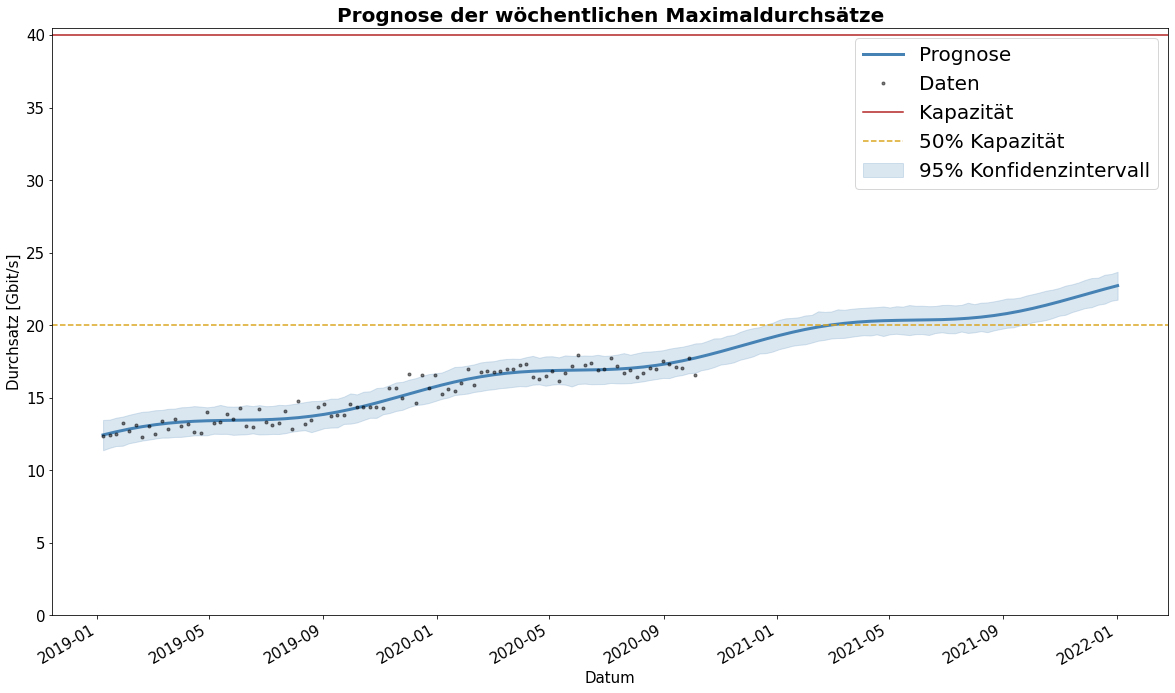

In [30]:
#------------------
# Plot die Prognose
#------------------
ax = forecast_weekly2.plot(x="ds", y="yhat", label='Prognose', color="steelblue", linewidth=3)
ax.fill_between(forecast_weekly2['ds'].values, forecast_weekly2.yhat_lower, forecast_weekly2.yhat_upper, label='95% Konfidenzintervall', color='steelblue', alpha=.2)
df_weekly_model_input2.plot(x="ds", y="y", label='Daten', ax=ax, marker='o', ms = 3, color="black", alpha=0.5, figsize=(20, 12), linestyle = 'None')
ax.axhline(y=max_capacity_single, label='Kapazität', color='firebrick')
ax.axhline(y=max_capacity_single/2, label='50% Kapazität', color='goldenrod', linestyle='--') 
#------------------
#------------------

# Setze Plot-Eigenschaften
ax.set_title('Prognose der wöchentlichen Maximaldurchsätze', fontweight="bold", size=20) # Title
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim(0,max_capacity_single+0.5)
ax.set_ylabel('Durchsatz [Gbit/s]', fontsize = 15) # Y label
ax.set_xlabel('Datum', fontsize = 15) # X label
ax.legend(loc=0, prop={'size': 20} )